# Statistical analysis
This notebook performs differential expression analysis using the real template experiment and simulated experiments, as a null set. Then the set of differentially expressed genes (DEGs) obtained from this analysis are used to perform gene set enrichment analysis (GSEA) to identify pathways enriched in these set of DEGs.

In [11]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# User selected experiment id
project_id = "SRP000762"

In [4]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
num_runs=25

In [5]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    "SRP000762_groups.tsv")

## Install R libraries

In [6]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")
#BiocManager::install('EnhancedVolcano')
#devtools::install_github('kevinblighe/EnhancedVolcano')
#BiocManager::install('clusterProfiler')
#BiocManager::install("org.Hs.eg.db")

NULL


## Differential expression analysis

In [7]:
%%R
library('limma')

**Get differentially expressed genes from template experiment**

In [8]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../functions/DE_analysis.R')

get_DE_stats(metadata_file,
             project_id, 
             template_data_file,
             "template",
             local_dir,
             "real")

[1] 60


**Get differentially expressed genes from each simulated experiment**

In [9]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -o num_sign_DEGs_simulated

source('../functions/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
  simulated_data_file <- paste(local_dir, "pseudo_experiment/selected_simulated_data_", project_id, "_", i, ".txt", sep="")
  cat(paste("running file: ", simulated_data_file, "...\n", sep=""))
  
  run_output <- get_DE_stats(metadata_file,
                             project_id, 
                             simulated_data_file,
                             "simulated",
                             local_dir,
                             i)
  
  num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
}
median(num_sign_DEGs_simulated)

running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_0.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_1.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_2.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_3.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_4.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_5.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_6.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_7.txt...
running file: /home/alexandra/Documents/

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


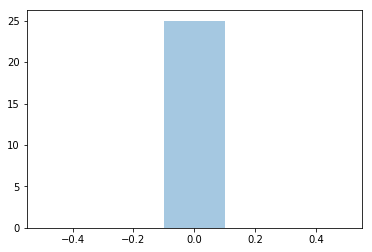

In [14]:
# Plot distribution of differentially expressed genes for simulated experiments
sns.distplot(num_sign_DEGs_simulated,
            kde=False)

**Observation:** All simulated experiments found 0 DEGs using adjusted p-value cutoff of <5%

**Check**

As a check, we compared the number of DEGs identified here versus what was reported in the [Reddy et. al. publication](https://www.ncbi.nlm.nih.gov//pubmed/19801529), which found:
* 234 genes with a significant (FDR < 5%) change in expression in response to DEX treatment. 
* After removing pseudogenes (listed in Supplemental Table S3), 209 differentially expressed genes remained 
* Of the DEX-responsive genes, more showed increases in transcript levels 123 (59%) than showed decreases 86 (41%), and the up-regulation was slightly but significantly stronger than the down-regulation

By comparison:
* Our study found 60 DEGs instead of 234. 
* Spot checking the genes identified with their list of DEX-responsive genes (Supplementary Dataset 2), we found the same genes and FC direction was consistent though magnitudes of theirs was lower compared to ours. 

In [15]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

In [16]:
template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

template_DEGs = template_DE_stats[template_DE_stats['adj.P.Val']<0.05]
print(template_DEGs.shape)
template_DEGs.head()

(60, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000067082.14,19.385246,18.673139,14.055682,2.342010e-12,1.359233e-07,9.739709
ENSG00000177606.6,-8.236487,9.185753,-13.126898,8.859555e-12,2.570910e-07,9.292456
ENSG00000114315.3,-6.285228,6.042663,-12.840532,1.355507e-11,2.622318e-07,9.141666
ENSG00000185950.8,8.790781,17.705828,12.594113,1.966140e-11,2.852721e-07,9.006626
ENSG00000095752.6,-7.505790,7.299177,-12.204218,3.582671e-11,4.158550e-07,8.782431


In [17]:
#%%R
#library(EnhancedVolcano)

In [18]:
#%%R -i project_id -i template_DE_stats_file -i local_dir

#source('../functions/DE_analysis.R')

#create_volcano(template_DE_stats_file,
#               project_id,
#               "adj.P.Val",
#               local_dir)

## Gene set enrichment analysis
Use DE association statistics to rank pathways that are enriched within GO pathways

In [19]:
%%R
library(clusterProfiler)
library(org.Hs.eg.db)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/py

**Get pathway enrichment for template experiment**

In [23]:
%%R -i template_DE_stats_file  -o enriched_pathways

source('../functions/GSEA_analysis.R')

enriched_pathways <- find_enriched_pathways(template_DE_stats_file)

In [25]:
print(enriched_pathways.shape)
enriched_pathways.head()

(938, 12)


,ONTOLOGY,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
0,MF,GO:0000049,tRNA binding,60,0.525192,1.546042,0.000999,0.014062,0.011364,17488,"tags=52%, list=30%, signal=36%",ENSG00000124571/ENSG00000129480/ENSG0000007250...
1,BP,GO:0000070,mitotic sister chromatid segregation,152,0.515293,1.603883,0.000999,0.014062,0.011364,16866,"tags=52%, list=29%, signal=37%",ENSG00000154473/ENSG00000121152/ENSG0000016784...
2,BP,GO:0000075,cell cycle checkpoint,215,0.486637,1.538406,0.000999,0.014062,0.011364,16017,"tags=47%, list=28%, signal=34%",ENSG00000182973/ENSG00000154473/ENSG0000016841...
3,BP,GO:0000077,DNA damage checkpoint,144,0.487972,1.514622,0.000999,0.014062,0.011364,17564,"tags=49%, list=30%, signal=34%",ENSG00000182973/ENSG00000168411/ENSG0000013984...
4,BP,GO:0000082,G1/S transition of mitotic cell cycle,267,0.439629,1.402439,0.000999,0.014062,0.011364,14089,"tags=37%, list=24%, signal=28%",ENSG00000198987/ENSG00000199157/ENSG0000020759...


**Get pathway enrichment for simulated experiments**

In [29]:
%%R -i project_id -i local_dir -i num_runs 

source('../functions/GSEA_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_DE_stats_file <- paste(local_dir, 
                                 "DE_stats/DE_stats_simulated_data_", 
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    cat(paste("running file: ", simulated_DE_stats_file, "...\n", sep=""))
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file)
    
    out_file = paste(local_dir, "GSEA_stats/GSEA_simulated_data_", project_id,"_", i, ".txt", sep="")
    write.table(enriched_pathways, file = out_file, row.names = T, sep = "\t", quote = F)
    }

running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_0.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_1.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_2.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_3.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_4.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_5.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_6.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_7.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_8.txt...
r

**Check**

Again, we want to compare our ranked pathways found against what was reported in the original publication.

*The DEX-responsive genes that we identified are primarily implicated in two broad classes: stress response and development (Table 1; Reimand et al. 2007). Comparison to Gene Ontology (GO) categories (Ashburner et al. 2000) revealed that the identified genes are involved in stress response (P = 6 × 10−11), organ development (P = 5 × 10−15), cell differentiation (P = 1 × 10−11), hormone secretion (P = 4 × 10−7), and apoptosis (P = 5 × 10−12).*

## Statistics